# **EXPLORATORY DATA ANALYSIS (EDA) OF THE DATASET**

## Import Libraries

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
import random
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import json
from pymorphy2 import MorphAnalyzer
import pymorphy2
from nltk.tokenize import word_tokenize

In [ ]:
%%capture
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

## Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/__seminary_practice/Otchet"

/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/__seminary_practice/Otchet


## Stop Words

In [ ]:
morph = MorphAnalyzer()
stop_words_ru = set()
with open('stopwords-ru.txt', 'r', encoding='utf-8') as f:
    for word in f.readlines():
        stop_words_ru.add(morph.parse(word.strip())[0].normal_form)

In [ ]:
len(stop_words_ru)

386

In [ ]:
ru_stop_words = pd.read_csv('stopwords-ru.txt',header=None)

In [ ]:
len(ru_stop_words)

559

We will use ``ru_stop_words``

## Load the Dataset

In [ ]:
file_path_without_lab = 'sums_lang_for_news.xlsx'
file_path_with_labels = 'sentiment_full.xlsx'
file_path_complete = 'страны_партнеры_с_тональностью_общий_271123.xlsx'

df_unlabelled = pd.read_excel(file_path_without_lab)
df_labelled = pd.read_excel(file_path_with_labels)
df = pd.read_excel(file_path_complete, usecols=lambda x: x != 'Unnamed: 9')

In [ ]:
column_rename_dict = {
    'Тип отношений': 'Relationship Type',
    'Коды МСТК': 'MSTK Codes',
    'Страны': 'Countries',
    'Событие': 'text',
    'Источник': 'Source',
    'Дата': 'Date',
    'Тональность': 'sentiment'
}

df_labelled.rename(columns=column_rename_dict, inplace=True)

In [ ]:
sentiment_mapping = {0: 'neutral', -1: 'negative', 1: 'positive'}

df_labelled['sentiment'] = df_labelled['sentiment'].replace(sentiment_mapping)

df_labelled.head()

,Relationship Type,MSTK Codes,Countries,text,Source,Date,sentiment
0,Внешняя торговля; Санкции,75 - Канцелярские машины и оборудование для ав...,"Венесуэла, Китай, Россия, США",США в очередной раз ужесточили правила экспорт...,https://www.rbc.ru/economics/30/06/2020/5ef9e4...,2020-06-30,negative
1,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272)...,"Бразилия, Россия","Санкции, введенные против России, такие как ис...",https://www1.folha.uol.com.br/internacional/en...,2022-03-02,negative
2,Санкции; Внешняя торговля,56 - Удобрения (кроме включенных в группу 272),"Бразилия, Россия, Разные Страны Африки, Разные...",Посол Бразилии в Организации Объединенных Наци...,https://www1.folha.uol.com.br/internacional/en...,2022-03-07,negative
3,Санкции,"93 - Специальные операции и товары, не классиф...","Россия, Индонезия, Таиланд",Беспрецедентные санкции против российских банк...,https://www.thejakartapost.com/paper/2022/03/1...,2022-03-11,negative
4,Внешняя торговля; Санкции,"33 - Нефть, нефтепродукты и аналогичные материалы","Индонезия, Россия, Разные Страны Европы и Севе...",Государственная энергетическая компания Индоне...,https://jakartaglobe.id/business/too-cheap-to-...,2022-03-29,positive


We need text classification for titles and for news texts.

In [ ]:
df_titles = df[['title', 'sentiment']]
df_text = df_labelled[['text', 'sentiment']]

## Explore the Basic Properties of the Dataset

### Shape of the dataset

In [ ]:
print(f"Shape of texts (rows, cols)=> {df_text.shape}")
print(f"Shape of titles (rows, cols)=> {df_titles.shape}")

Shape of texts (rows, cols)=> (584, 2)
Shape of titles (rows, cols)=> (486, 2)


### Check the duplicates


In [ ]:
df_text.describe(include='all')

,text,sentiment
count,584,584
unique,583,3
top,Бразильские предприятия по производству вакцин...,positive
freq,2,219


In [ ]:
df_titles.describe(include='all')

,title,sentiment
count,486,486
unique,484,3
top,Экспорт российского мороженого в 2022 году упа...,negative
freq,2,291


In [ ]:
df_titles.title.duplicated(keep="first").value_counts()

title
False    484
True       2
Name: count, dtype: int64

In [ ]:
df_text.text.duplicated(keep="first").value_counts()

text
False    583
True       1
Name: count, dtype: int64

In [ ]:
df_text = df_text.drop_duplicates(subset="text", keep="first").reset_index(drop=True)
df_text.describe()

,text,sentiment
count,583,583
unique,583,3
top,США в очередной раз ужесточили правила экспорт...,positive
freq,1,218


In [ ]:
df_titles = df_titles.drop_duplicates(subset="title", keep="first").reset_index(drop=True)
df_titles.describe()

,title,sentiment
count,484,484
unique,484,3
top,Экс-глава итальянского правительства Сильвио Б...,negative
freq,1,290


# **Work with text and Augment the data**

## Analyze the Classes (Sentiments)

### Topic List

In [ ]:
sentiment_list = df_text.sentiment.unique()
print("Sentiments:\n", sentiment_list)

Sentiments:
 ['negative' 'positive' 'neutral']


In [ ]:
number_of_sentiments = len(sentiment_list)
print("Number of Topics: ",number_of_sentiments)

Number of Topics:  3


### Number of texts per Sentiments

In [ ]:
df_text.sentiment.value_counts()

sentiment
positive    218
neutral     185
negative    180
Name: count, dtype: int64

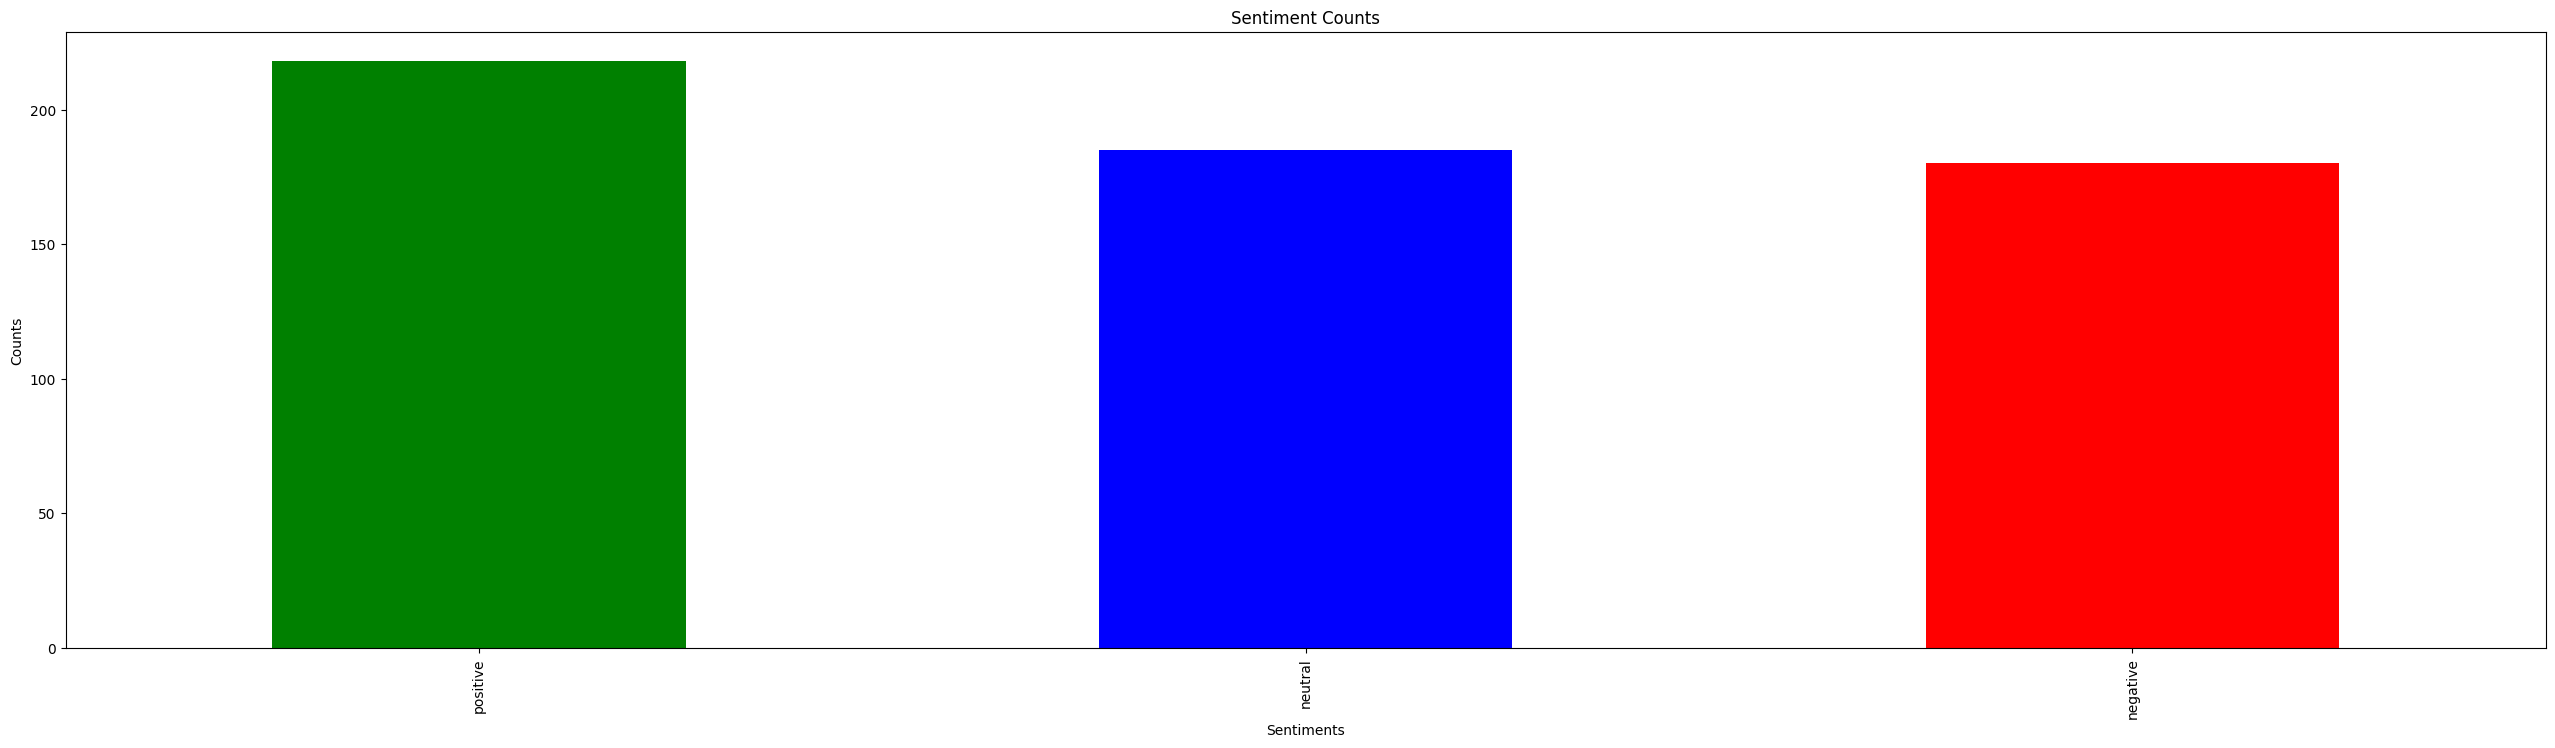

In [ ]:
df_text.sentiment.value_counts().plot.bar(x="Sentiments", y="Texts", figsize=(32, 8), color=['green', 'blue', 'red'])

plt.title('Sentiment Counts')
plt.xlabel('Sentiments')
plt.ylabel('Counts')

plt.show()

The dataset is **balanced (more or less)**: the number of samples are almost evenly distrubuted over the sentiments.

The dataset is too small and we need to **augment** it.

In [ ]:
%%capture
!pip install spacy
!python -m spacy download ru_core_news_sm

In [ ]:
import spacy
nlp = spacy.blank("ru")

def augment_text_with_spacy(text):
    doc = nlp(text)
    augmented_text = " ".join([token.text for token in doc])
    return augmented_text

df = df_text

sample_size = 150000 #len(df)

augmented_texts = []
augmented_sentiments = []
for idx, row in df.sample(sample_size, replace=True).iterrows():
    text = row['text']
    sentiment = row['sentiment']
    augmented_text = augment_text_with_spacy(text)
    augmented_texts.append(augmented_text)
    augmented_sentiments.append(sentiment)

augmented_df = pd.DataFrame({'text': augmented_texts, 'sentiment': augmented_sentiments})

df_augmented = pd.concat([df, augmented_df], ignore_index=True)

print(df_augmented.head())

                                                text sentiment
0  США в очередной раз ужесточили правила экспорт...  negative
1  Санкции, введенные против России, такие как ис...  negative
2  Посол Бразилии в Организации Объединенных Наци...  negative
3  Беспрецедентные санкции против российских банк...  negative
4  Государственная энергетическая компания Индоне...  positive


In [ ]:
df_text = df_augmented

## Analyze News (Text)

### Calculate the number of words in each reviews

In [ ]:
df_text['words'] = df_text['text'].apply(lambda x: len(word_tokenize(x)))

In [ ]:
df_text.tail()

,text,sentiment,words
150578,Тайские производители стали обеспокоены приток...,negative,24
150579,Американская компания Exxon остановила добычу ...,negative,44
150580,Управление по контролю за иностранными активам...,negative,34
150581,"Торговое судно , находящееся под санкциями США...",neutral,51
150582,Санкции в отношении пяти компаний из КНР были ...,negative,55


### Review Length in terms of Number of Words

In [ ]:
df_text['words'].describe()

count    150583.000000
mean         65.932575
std          43.508609
min           8.000000
25%          33.000000
50%          55.000000
75%          87.000000
max         289.000000
Name: words, dtype: float64

### Review Length in terms of Number of Words per Topic

In [ ]:
df_text.groupby(['sentiment'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,46127.0,65.799597,44.574975,13.0,31.0,55.0,88.0,233.0
neutral,48066.0,60.494341,40.692439,14.0,33.0,45.0,75.0,284.0
positive,56390.0,70.676822,44.391680,8.0,35.0,64.0,93.0,289.0


### Number of short reviews

We can check the number of short reviews by comparing a threshold:

In [ ]:
min_review_size = 9
df_text[df_text['words']>min_review_size].count()

text         150308
sentiment    150308
words        150308
dtype: int64

Let's see some short review samples:

In [ ]:
df_text[df_text['words']<min_review_size]

,text,sentiment,words
18,Турция не будет вводить санкции против России.,positive,8
1189,Турция не будет вводить санкции против России .,positive,8
1565,Турция не будет вводить санкции против России .,positive,8
2878,Турция не будет вводить санкции против России .,positive,8
2912,Турция не будет вводить санкции против России .,positive,8
...,...,...,...
148270,Турция не будет вводить санкции против России .,positive,8
149262,Турция не будет вводить санкции против России .,positive,8
150062,Турция не будет вводить санкции против России .,positive,8
150165,Турция не будет вводить санкции против России .,positive,8


###  Decide minimum and maximum review size

In [ ]:
min_review_size = 10
max_review_size = 60

In [ ]:
df_text.count()

text         150583
sentiment    150583
words        150583
dtype: int64

In [ ]:
data = df_text[df_text['words']>=min_review_size]

In [ ]:
data[data['words']<min_review_size].count()

text         0
sentiment    0
words        0
dtype: int64

## Analyze the Vocabulary



### Count the distinct words

Let's look into the **raw** dataset to count the **distinct words**

In [ ]:
vocab = {word.lower() for sentence in [x.split() for x in data['text'].tolist()] for word in sentence}
print("Number of distinct words in raw data:", len(vocab))

Number of distinct words in raw data: 11220


In [ ]:
vocab_size = len(vocab)

### Count the frequency of words in the raw dataset

In [ ]:
word_freq = (
    data.text.str.split(expand=True)
    .stack()
    .value_counts()
    .reset_index(name='freq')
    .rename(columns={'index': 'word'})
)

Let's check the **top 50** words:

In [ ]:
top_50_frequent_words = word_freq[:50]
top_50_frequent_words

,word,freq
0,",",614230
1,.,409254
2,в,374725
3,и,246032
4,на,179674
5,с,110462
6,из,110322
7,России,93268
8,-,84447
9,за,72745


Let's see which **top-50** frequent words are in the **stop-word** list that we loaded at the beginning:

In [ ]:
count = 0
for each in top_50_frequent_words['word']:
  if each in ru_stop_words.values:
    count += 1
    print(each)

в
и
на
с
из
за
что
по
года
для
не
к
против
как
до
от
о
также
которые
году


In [ ]:
print(f"Almost {count} words out of the top-50 words are stop words. Therefore, during preprocessing, we could take care of the stop-words.")

Almost 20 words out of the top-50 words are stop words. Therefore, during preprocessing, we could take care of the stop-words.
